In [6]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from tqdm import tqdm
import json
from sklearn.model_selection import RandomizedSearchCV

import os, sys
sys.path.append(os.path.abspath(".."))

from utils.training_storage_helper import save_params, save_model

seed = 42
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from tqdm import tqdm
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted

class ProgressWrapper:
    """
    Lớp bao bọc để thêm thanh tiến trình `tqdm` cho quá trình huấn luyện của bất kỳ mô hình nào từ Scikit-learn.
    """
    def __init__(self, model):
        self.model = clone(model)

    def fit(self, X, y, **fit_params):
        # Đếm tổng số cây (estimators) được xây dựng trong RandomForestClassifier
        n_estimators = getattr(self.model, 'n_estimators', 1)

        with tqdm(total=n_estimators, desc="Training", unit="tree") as pbar:
            original_fit = self.model.fit

            def fit_and_update(*args, **kwargs):
                for i in range(n_estimators):
                    original_fit(*args, **kwargs)
                    pbar.update(1)

            self.model.fit = fit_and_update
            try:
                self.model.fit(X, y, **fit_params)
            finally:
                self.model.fit = original_fit
                pbar.close()

        return self

    def predict(self, X):
        check_is_fitted(self.model)
        return self.model.predict(X)

    def predict_proba(self, X : np.ndarray):
        check_is_fitted(self.model)
        return self.model.predict_proba(X)

    def score(self, X, y):
        check_is_fitted(self.model)
        return self.model.score(X, y)

    def __getattr__(self, name):
        return getattr(self.model, name)

In [3]:
train_df = pd.read_csv("../../data/key_points_rotate_scale_feature_selection.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438 entries, 0 to 437
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               438 non-null    object 
 1   nose_x              438 non-null    float64
 2   left_shoulder_x     438 non-null    float64
 3   right_shoulder_x    438 non-null    float64
 4   left_elbow_x        438 non-null    float64
 5   right_elbow_x       438 non-null    float64
 6   left_pinky_x        438 non-null    float64
 7   right_pinky_x       438 non-null    float64
 8   left_index_x        438 non-null    float64
 9   right_index_x       438 non-null    float64
 10  left_hip_x          438 non-null    float64
 11  right_hip_x         438 non-null    float64
 12  left_knee_x         438 non-null    float64
 13  right_knee_x        438 non-null    float64
 14  left_foot_index_x   438 non-null    float64
 15  right_foot_index_x  438 non-null    float64
 16  nose_y  

In [5]:
train_df.columns

Index(['label', 'nose_x', 'left_shoulder_x', 'right_shoulder_x',
       'left_elbow_x', 'right_elbow_x', 'left_pinky_x', 'right_pinky_x',
       'left_index_x', 'right_index_x', 'left_hip_x', 'right_hip_x',
       'left_knee_x', 'right_knee_x', 'left_foot_index_x',
       'right_foot_index_x', 'nose_y', 'left_shoulder_y', 'right_shoulder_y',
       'left_elbow_y', 'right_elbow_y', 'left_pinky_y', 'right_pinky_y',
       'left_index_y', 'right_index_y', 'left_hip_y', 'right_hip_y',
       'left_knee_y', 'right_knee_y', 'left_foot_index_y',
       'right_foot_index_y', 'nose_z', 'left_shoulder_z', 'right_shoulder_z',
       'left_elbow_z', 'right_elbow_z', 'left_pinky_z', 'right_pinky_z',
       'left_index_z', 'right_index_z', 'left_hip_z', 'right_hip_z',
       'left_knee_z', 'right_knee_z', 'left_foot_index_z',
       'right_foot_index_z'],
      dtype='object')

In [6]:
train_df.head()

,label,nose_x,left_shoulder_x,right_shoulder_x,left_elbow_x,right_elbow_x,left_pinky_x,right_pinky_x,left_index_x,right_index_x,...,left_pinky_z,right_pinky_z,left_index_z,right_index_z,left_hip_z,right_hip_z,left_knee_z,right_knee_z,left_foot_index_z,right_foot_index_z
0,1_lie_on,0.363741,0.467764,0.196310,0.565565,0.122049,0.670879,0.025576,0.638539,0.043470,...,0.010140,-0.058798,-0.032806,-0.103520,-0.005109,0.005414,-0.368347,-0.327776,-0.166788,-0.190334
1,1_lie_on,0.015858,0.142380,-0.093123,0.255212,-0.200345,0.436034,-0.388422,0.427783,-0.383346,...,-0.168743,-0.159482,-0.206809,-0.204821,-0.001068,0.001386,-0.368634,-0.323120,-0.046716,-0.097076
2,1_lie_on,-0.004898,0.140344,-0.169599,0.252667,-0.303420,0.222667,-0.451471,0.215250,-0.408141,...,-1.060014,-0.934040,-1.053337,-0.957052,0.057617,-0.057271,-0.121838,-0.212551,0.287587,0.005253
3,1_lie_on,-0.001934,0.074425,-0.213412,0.214237,-0.342708,0.431742,-0.543946,0.422582,-0.542485,...,-0.533846,-0.436325,-0.564682,-0.476603,0.005199,-0.004301,-0.424671,-0.369049,-0.285776,-0.380920
4,1_lie_on,-0.023580,0.123704,-0.130584,0.268966,-0.258434,0.134875,-0.150976,0.116954,-0.134052,...,-0.021804,-0.161166,0.039035,-0.091750,0.000962,-0.000912,-0.381305,-0.452312,-0.119508,-0.203064


<Axes: xlabel='label', ylabel='count'>

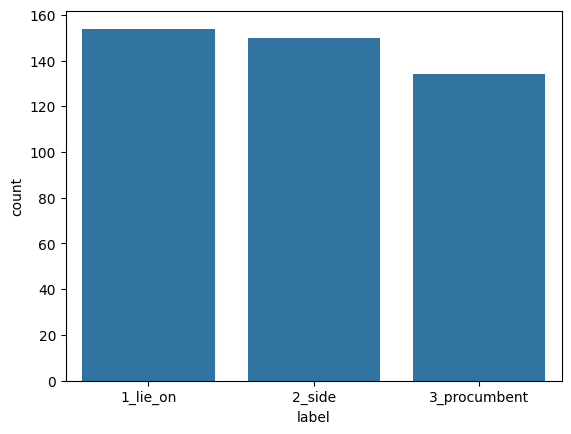

In [7]:
sns.countplot(x="label", data=train_df)

In [8]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [9]:
# Extract features
X_train = train_df.drop(columns="label")
y_train = train_df["label"]

In [10]:
X_train.head()

,nose_x,left_shoulder_x,right_shoulder_x,left_elbow_x,right_elbow_x,left_pinky_x,right_pinky_x,left_index_x,right_index_x,left_hip_x,...,left_pinky_z,right_pinky_z,left_index_z,right_index_z,left_hip_z,right_hip_z,left_knee_z,right_knee_z,left_foot_index_z,right_foot_index_z
0,0.363741,0.467764,0.196310,0.565565,0.122049,0.670879,0.025576,0.638539,0.043470,0.428014,...,0.010140,-0.058798,-0.032806,-0.103520,-0.005109,0.005414,-0.368347,-0.327776,-0.166788,-0.190334
1,0.015858,0.142380,-0.093123,0.255212,-0.200345,0.436034,-0.388422,0.427783,-0.383346,0.094494,...,-0.168743,-0.159482,-0.206809,-0.204821,-0.001068,0.001386,-0.368634,-0.323120,-0.046716,-0.097076
2,-0.004898,0.140344,-0.169599,0.252667,-0.303420,0.222667,-0.451471,0.215250,-0.408141,0.077138,...,-1.060014,-0.934040,-1.053337,-0.957052,0.057617,-0.057271,-0.121838,-0.212551,0.287587,0.005253
3,-0.001934,0.074425,-0.213412,0.214237,-0.342708,0.431742,-0.543946,0.422582,-0.542485,0.021697,...,-0.533846,-0.436325,-0.564682,-0.476603,0.005199,-0.004301,-0.424671,-0.369049,-0.285776,-0.380920
4,-0.023580,0.123704,-0.130584,0.268966,-0.258434,0.134875,-0.150976,0.116954,-0.134052,0.083857,...,-0.021804,-0.161166,0.039035,-0.091750,0.000962,-0.000912,-0.381305,-0.452312,-0.119508,-0.203064


In [11]:
y_train

0      0
1      0
2      0
3      0
4      0
      ..
433    2
434    2
435    2
436    2
437    2
Name: label, Length: 438, dtype: int32

In [12]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)

In [13]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

,nose_x,left_shoulder_x,right_shoulder_x,left_elbow_x,right_elbow_x,left_pinky_x,right_pinky_x,left_index_x,right_index_x,left_hip_x,...,left_pinky_z,right_pinky_z,left_index_z,right_index_z,left_hip_z,right_hip_z,left_knee_z,right_knee_z,left_foot_index_z,right_foot_index_z
0,0.363741,0.467764,0.196310,0.565565,0.122049,0.670879,0.025576,0.638539,0.043470,0.428014,...,0.010140,-0.058798,-0.032806,-0.103520,-0.005109,0.005414,-0.368347,-0.327776,-0.166788,-0.190334
1,0.015858,0.142380,-0.093123,0.255212,-0.200345,0.436034,-0.388422,0.427783,-0.383346,0.094494,...,-0.168743,-0.159482,-0.206809,-0.204821,-0.001068,0.001386,-0.368634,-0.323120,-0.046716,-0.097076
2,-0.004898,0.140344,-0.169599,0.252667,-0.303420,0.222667,-0.451471,0.215250,-0.408141,0.077138,...,-1.060014,-0.934040,-1.053337,-0.957052,0.057617,-0.057271,-0.121838,-0.212551,0.287587,0.005253
3,-0.001934,0.074425,-0.213412,0.214237,-0.342708,0.431742,-0.543946,0.422582,-0.542485,0.021697,...,-0.533846,-0.436325,-0.564682,-0.476603,0.005199,-0.004301,-0.424671,-0.369049,-0.285776,-0.380920
4,-0.023580,0.123704,-0.130584,0.268966,-0.258434,0.134875,-0.150976,0.116954,-0.134052,0.083857,...,-0.021804,-0.161166,0.039035,-0.091750,0.000962,-0.000912,-0.381305,-0.452312,-0.119508,-0.203064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,-0.107933,-0.121727,0.129897,-0.237271,0.235012,-0.174060,0.098353,-0.139736,0.074229,-0.049270,...,0.162137,0.331543,0.140403,0.307469,-0.070220,0.070101,0.352130,0.451922,0.796365,0.902307
434,-0.299182,-0.458020,-0.261410,-0.467668,-0.170198,-0.401491,-0.212844,-0.383742,-0.233029,-0.422733,...,0.461297,-0.040968,0.426410,-0.055059,0.061141,-0.061304,0.374028,0.207894,0.851679,0.716909
435,0.032266,0.080648,-0.031908,0.118758,-0.043313,-0.012729,-0.103394,-0.026806,-0.098770,0.058464,...,0.187120,-0.147184,0.205467,-0.161513,0.034117,-0.033706,0.491164,0.215990,0.870758,0.661160
436,0.009106,-0.098031,0.106148,-0.174500,0.234482,-0.241265,0.346388,-0.231150,0.335093,-0.061335,...,0.350486,-0.585468,0.345338,-0.563357,0.038802,-0.039987,0.331522,0.140088,0.041195,0.074022


In [14]:
import warnings
warnings.filterwarnings("ignore")

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [15]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X_train, y_train, cv=k_fold, scoring="accuracy", n_jobs=-1, verbose=1
    ).mean()

    f1_score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [16]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("SVC", SVC(probability=True, random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("RF", RandomForestClassifier(random_state=seed)),
    ("XGB", XGBClassifier(random_state=seed)),
]

models = {}
results_before_tunning = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model
    evaluate_model(name, model, results_before_tunning)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [17]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,RF,0.888166,0.885968
1,SVC,0.876724,0.874472
2,XGB,0.869854,0.867391
3,KNN,0.849190,0.847000
4,LR,0.831165,0.826366
5,DTC,0.780852,0.779766


<Axes: xlabel='F1 score', ylabel='Model'>

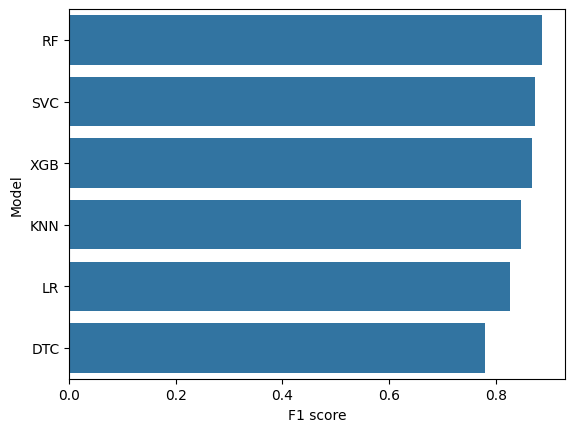

In [18]:
sns.barplot(x="F1 score", y="Model", data=print_results(results_before_tunning))

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [20]:
y_pred = models['SVC'].predict(X_train)
cm_full_train = confusion_matrix(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
cm_full_train, accuracy

(array([[146,   7,   1],
        [  5, 139,   6],
        [ 14,   5, 115]], dtype=int64),
 0.91324200913242)

In [21]:
svc_best_model = SVC(probability=True, random_state=seed)

svc_best_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [22]:
accuracy = cross_val_score(svc_best_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(svc_best_model, X_train, y_train, cv=k_fold)
cm_cross_val = confusion_matrix(y_train, y_pred)
accuracy, cm_cross_val

(0.8767241379310345,
 array([[146,   7,   1],
        [ 11, 129,  10],
        [ 14,  11, 109]], dtype=int64))

<Axes: >

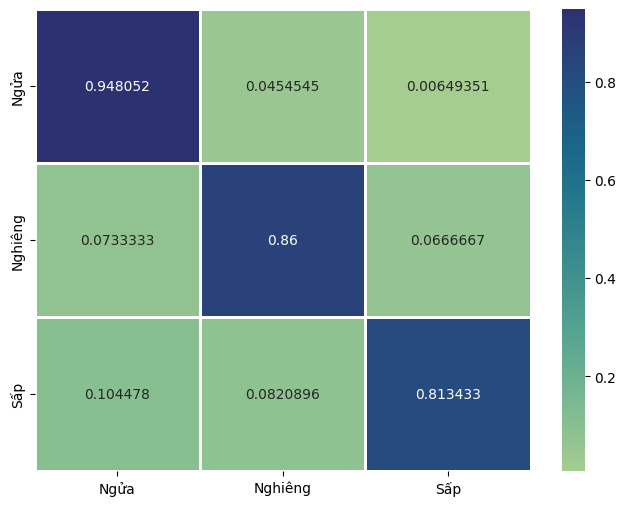

In [23]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["Ngửa", "Nghiêng", "Sấp"], columns=["Ngửa", "Nghiêng", "Sấp"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest")

# Find best model

In [28]:
results_after_tuning = []

In [26]:
random_forest = models["RF"]

  # Định nghĩa phạm vi của các siêu tham số cần tối ưu
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Tạo RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = random_forest, param_distributions = param_grid,
                                n_iter = 100, cv = k_fold, verbose=3, random_state=seed, n_jobs = -1)

# Tiến hành tìm kiếm siêu tham số
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}


In [27]:
random_search.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 50,
 'bootstrap': False}

In [4]:
save_params(random_search.best_params_, "./hyper_parameter/random_forest.json")

In [29]:
with open('./hyper_parameter/random_forest.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

# Khởi tạo một mô hình Random Forest mới với các tham số tối ưu
best_random_forest_model = RandomForestClassifier(**best_params, random_state=seed, verbose=1)
best_random_forest_model.fit(X_train, y_train)

# Huấn luyện mô hình mới với dữ liệu huấn luyện của bạn
result = []
evaluate_model("RF", best_random_forest_model, result)
results_after_tuning.append(result[0])
print_results(result)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s

,Model,Accuracy score,F1 score
0,RF,0.892659,0.891381


In [32]:
save_model(best_random_forest_model, "./models/random_forest.pkl")